In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
df = pd.read_csv("train.csv")

In [106]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<AxesSubplot:>

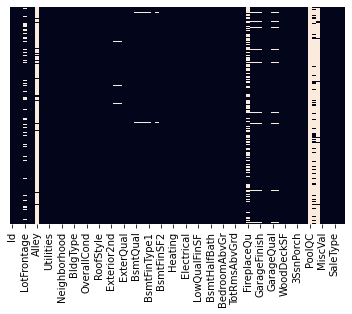

In [107]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [108]:
#Analysing the data

#There are many fields which don't have any values for over 80% of the rows. It only makes sense to drop them since
#they don't contribute to the prediction

df.drop(['Alley','GarageYrBlt','PoolQC','Fence','MiscFeature'],axis=1, inplace=True)
# df.drop(['Alley'],axis=1, inplace = True)

In [109]:
# Some fields have few NAN values, which can be for now filled with mean for numerical fields and mode for categorical fields
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

fields = ['BsmtCond', 'BsmtQual', 'FireplaceQu', 
          'GarageType', 'GarageFinish', 'GarageQual', 
          'GarageCond', 'MasVnrType', 'MasVnrArea', 
          'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

def cat_fill(fields):
    for field in fields:
        df[field] = df[field].fillna(df[field].mode()[0])
cat_fill(fields)

<AxesSubplot:>

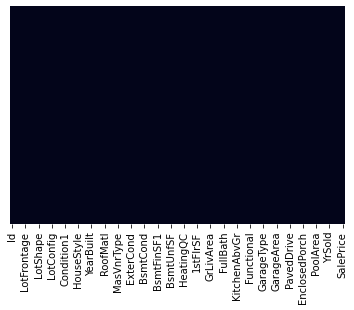

In [110]:
# Making sure that we dont have any NA fields
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [111]:
df.dropna(inplace=True)
df.drop(['Id'], axis=1, inplace=True)
df.shape

(1459, 75)

In [112]:
# get all the categorical fields
columns = list(df.select_dtypes(['object']).columns)

In [113]:
def convert_cat_to_bool(columns, df_final):
    final_df = df_final
    i = 0
    for field in columns:
        df1 = pd.get_dummies(df_final[field],drop_first=True)
        df_final.drop([field], axis=1, inplace=True)
        
        if i==0:
            final_df = df1.copy()
        else:
            final_df = pd.concat([final_df,df1], axis=1)
        i += 1
    df_final = pd.concat([df_final,final_df], axis=1)
    return df_final

In [114]:
main_df = df.copy()

In [115]:
test_df = pd.read_csv("formulatedtest.csv")
df.shape

(1459, 75)

In [116]:
df_final = pd.concat([test_df, df], axis=0)

In [117]:
df_final = convert_cat_to_bool(columns, df_final)

In [118]:
df_final.shape

(2918, 236)

In [119]:
df_final = df_final.loc[:,~df_final.columns.duplicated()]
df_final.shape

(2918, 176)

In [120]:
train = df_final.iloc[1459:,:]
test = df_final.iloc[:1459,:]

In [121]:
test.drop(['SalePrice'], axis=1, inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [122]:
train_y = train['SalePrice']
train.drop(['SalePrice'], axis=1, inplace=True)

In [123]:
train_y.head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [124]:
train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ConLI,ConLw,New,Oth,WD,AdjLand,Alloca,Family,Normal,Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,0,1,0,0,0,1,0


# Using Pytorch to develop a ML and Deep Learning Model to predict the house prices

In [125]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler    

In [126]:
input_size = 175
output_size = 1

sc = MinMaxScaler()
train = sc.fit_transform(train.values.reshape(-1,175))
test = sc.fit_transform(test.values.reshape(-1,175))

trainx_tensor = torch.tensor(train).float()
trainy_tensor = torch.tensor(train_y.values).view(-1,1).float()

testx_tensor = torch.tensor(test).float()

In [132]:
#pytorch neural net class
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.l1 = nn.Linear(input_size, 128)
        self.act1 = nn.ReLU()
        self.l2 = nn.Linear(128, 64)
        self.act2 = nn.ReLU()
        self.l3 = nn.Linear(64, 16)
        self.act3 = nn.ReLU()
        self.l4 = nn.Linear(16, output_size)
    def forward(self, x):
        y_pred = self.l1(x)
        y_pred = self.act1(y_pred)
        y_pred = self.l2(y_pred)
        y_pred = self.act2(y_pred)
        y_pred = self.l3(y_pred)
        y_pred = self.act3(y_pred)
        y_pred = self.l4(y_pred)
        return y_pred

In [133]:
trainx_tensor.shape

torch.Size([1459, 175])

In [134]:
trainy_tensor

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [135]:
testx_tensor.shape

torch.Size([1459, 175])

In [136]:
model = Net()
learning_rate = 0.0001
l = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

num_epochs = 2000
for epoch in range(num_epochs):
    y_pred = model(trainx_tensor)

    loss= torch.sqrt(l(y_pred, trainy_tensor))
    
    loss.backward()

    optimizer.step()

    optimizer.zero_grad()
    
    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 197602.53125
epoch 1, loss 197602.53125
epoch 2, loss 197602.53125
epoch 3, loss 197602.53125
epoch 4, loss 197602.53125
epoch 5, loss 197602.53125
epoch 6, loss 197602.53125
epoch 7, loss 197602.53125
epoch 8, loss 197602.53125
epoch 9, loss 197602.53125
epoch 10, loss 197602.53125
epoch 11, loss 197602.53125
epoch 12, loss 197602.53125
epoch 13, loss 197602.53125
epoch 14, loss 197602.53125
epoch 15, loss 197602.53125
epoch 16, loss 197602.53125
epoch 17, loss 197602.53125
epoch 18, loss 197602.53125
epoch 19, loss 197602.53125
epoch 20, loss 197602.53125
epoch 21, loss 197602.53125
epoch 22, loss 197602.53125
epoch 23, loss 197602.53125
epoch 24, loss 197602.53125
epoch 25, loss 197602.53125
epoch 26, loss 197602.53125
epoch 27, loss 197602.53125
epoch 28, loss 197602.53125
epoch 29, loss 197602.53125
epoch 30, loss 197602.53125
epoch 31, loss 197602.53125
epoch 32, loss 197602.53125
epoch 33, loss 197602.53125
epoch 34, loss 197602.53125
epoch 35, loss 197602.53125
ep

epoch 313, loss 197602.484375
epoch 314, loss 197602.484375
epoch 315, loss 197602.484375
epoch 316, loss 197602.484375
epoch 317, loss 197602.484375
epoch 318, loss 197602.484375
epoch 319, loss 197602.484375
epoch 320, loss 197602.484375
epoch 321, loss 197602.484375
epoch 322, loss 197602.484375
epoch 323, loss 197602.484375
epoch 324, loss 197602.484375
epoch 325, loss 197602.484375
epoch 326, loss 197602.484375
epoch 327, loss 197602.484375
epoch 328, loss 197602.484375
epoch 329, loss 197602.484375
epoch 330, loss 197602.484375
epoch 331, loss 197602.484375
epoch 332, loss 197602.484375
epoch 333, loss 197602.484375
epoch 334, loss 197602.484375
epoch 335, loss 197602.484375
epoch 336, loss 197602.484375
epoch 337, loss 197602.484375
epoch 338, loss 197602.484375
epoch 339, loss 197602.484375
epoch 340, loss 197602.484375
epoch 341, loss 197602.484375
epoch 342, loss 197602.484375
epoch 343, loss 197602.484375
epoch 344, loss 197602.484375
epoch 345, loss 197602.484375
epoch 346,

epoch 601, loss 197602.453125
epoch 602, loss 197602.453125
epoch 603, loss 197602.453125
epoch 604, loss 197602.453125
epoch 605, loss 197602.453125
epoch 606, loss 197602.453125
epoch 607, loss 197602.453125
epoch 608, loss 197602.453125
epoch 609, loss 197602.453125
epoch 610, loss 197602.453125
epoch 611, loss 197602.453125
epoch 612, loss 197602.453125
epoch 613, loss 197602.453125
epoch 614, loss 197602.453125
epoch 615, loss 197602.453125
epoch 616, loss 197602.453125
epoch 617, loss 197602.453125
epoch 618, loss 197602.453125
epoch 619, loss 197602.453125
epoch 620, loss 197602.453125
epoch 621, loss 197602.453125
epoch 622, loss 197602.453125
epoch 623, loss 197602.453125
epoch 624, loss 197602.453125
epoch 625, loss 197602.453125
epoch 626, loss 197602.453125
epoch 627, loss 197602.453125
epoch 628, loss 197602.453125
epoch 629, loss 197602.453125
epoch 630, loss 197602.453125
epoch 631, loss 197602.453125
epoch 632, loss 197602.453125
epoch 633, loss 197602.453125
epoch 634,

epoch 874, loss 197602.421875
epoch 875, loss 197602.421875
epoch 876, loss 197602.421875
epoch 877, loss 197602.421875
epoch 878, loss 197602.421875
epoch 879, loss 197602.421875
epoch 880, loss 197602.421875
epoch 881, loss 197602.421875
epoch 882, loss 197602.421875
epoch 883, loss 197602.421875
epoch 884, loss 197602.421875
epoch 885, loss 197602.421875
epoch 886, loss 197602.421875
epoch 887, loss 197602.421875
epoch 888, loss 197602.421875
epoch 889, loss 197602.421875
epoch 890, loss 197602.421875
epoch 891, loss 197602.421875
epoch 892, loss 197602.421875
epoch 893, loss 197602.421875
epoch 894, loss 197602.421875
epoch 895, loss 197602.421875
epoch 896, loss 197602.421875
epoch 897, loss 197602.421875
epoch 898, loss 197602.421875
epoch 899, loss 197602.421875
epoch 900, loss 197602.421875
epoch 901, loss 197602.421875
epoch 902, loss 197602.421875
epoch 903, loss 197602.421875
epoch 904, loss 197602.421875
epoch 905, loss 197602.421875
epoch 906, loss 197602.421875
epoch 907,

epoch 1156, loss 197602.40625
epoch 1157, loss 197602.40625
epoch 1158, loss 197602.40625
epoch 1159, loss 197602.40625
epoch 1160, loss 197602.40625
epoch 1161, loss 197602.40625
epoch 1162, loss 197602.40625
epoch 1163, loss 197602.40625
epoch 1164, loss 197602.40625
epoch 1165, loss 197602.40625
epoch 1166, loss 197602.40625
epoch 1167, loss 197602.40625
epoch 1168, loss 197602.40625
epoch 1169, loss 197602.40625
epoch 1170, loss 197602.40625
epoch 1171, loss 197602.40625
epoch 1172, loss 197602.40625
epoch 1173, loss 197602.40625
epoch 1174, loss 197602.40625
epoch 1175, loss 197602.40625
epoch 1176, loss 197602.40625
epoch 1177, loss 197602.40625
epoch 1178, loss 197602.40625
epoch 1179, loss 197602.40625
epoch 1180, loss 197602.40625
epoch 1181, loss 197602.40625
epoch 1182, loss 197602.40625
epoch 1183, loss 197602.40625
epoch 1184, loss 197602.40625
epoch 1185, loss 197602.40625
epoch 1186, loss 197602.40625
epoch 1187, loss 197602.40625
epoch 1188, loss 197602.40625
epoch 1189

epoch 1452, loss 197602.359375
epoch 1453, loss 197602.359375
epoch 1454, loss 197602.359375
epoch 1455, loss 197602.359375
epoch 1456, loss 197602.359375
epoch 1457, loss 197602.359375
epoch 1458, loss 197602.359375
epoch 1459, loss 197602.359375
epoch 1460, loss 197602.359375
epoch 1461, loss 197602.359375
epoch 1462, loss 197602.359375
epoch 1463, loss 197602.359375
epoch 1464, loss 197602.359375
epoch 1465, loss 197602.359375
epoch 1466, loss 197602.359375
epoch 1467, loss 197602.359375
epoch 1468, loss 197602.359375
epoch 1469, loss 197602.359375
epoch 1470, loss 197602.359375
epoch 1471, loss 197602.359375
epoch 1472, loss 197602.359375
epoch 1473, loss 197602.359375
epoch 1474, loss 197602.359375
epoch 1475, loss 197602.359375
epoch 1476, loss 197602.359375
epoch 1477, loss 197602.359375
epoch 1478, loss 197602.359375
epoch 1479, loss 197602.359375
epoch 1480, loss 197602.359375
epoch 1481, loss 197602.359375
epoch 1482, loss 197602.359375
epoch 1483, loss 197602.359375
epoch 14

epoch 1733, loss 197602.328125
epoch 1734, loss 197602.328125
epoch 1735, loss 197602.328125
epoch 1736, loss 197602.328125
epoch 1737, loss 197602.328125
epoch 1738, loss 197602.328125
epoch 1739, loss 197602.328125
epoch 1740, loss 197602.328125
epoch 1741, loss 197602.328125
epoch 1742, loss 197602.328125
epoch 1743, loss 197602.328125
epoch 1744, loss 197602.328125
epoch 1745, loss 197602.328125
epoch 1746, loss 197602.328125
epoch 1747, loss 197602.328125
epoch 1748, loss 197602.328125
epoch 1749, loss 197602.328125
epoch 1750, loss 197602.328125
epoch 1751, loss 197602.328125
epoch 1752, loss 197602.328125
epoch 1753, loss 197602.328125
epoch 1754, loss 197602.328125
epoch 1755, loss 197602.328125
epoch 1756, loss 197602.328125
epoch 1757, loss 197602.328125
epoch 1758, loss 197602.328125
epoch 1759, loss 197602.328125
epoch 1760, loss 197602.328125
epoch 1761, loss 197602.328125
epoch 1762, loss 197602.328125
epoch 1763, loss 197602.328125
epoch 1764, loss 197602.328125
epoch 17

In [137]:
y_predicted = model(testx_tensor).detach().numpy()
y_predicted

array([[0.33918172],
       [0.33232456],
       [0.33805028],
       ...,
       [0.34848905],
       [0.3407757 ],
       [0.34447208]], dtype=float32)

In [88]:
sub_df=pd.read_csv('sample_submission.csv')
y = pd.DataFrame(y_predicted)
datasets=pd.concat([sub_df['Id'],y],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission1.csv',index=False)